# Time series forecasting fundamentals with TensorFlow + Milestone Project 3 : BitPredict 💰📈

⚠️**Note**: This is not financial advice.

Links:
* All resources: https://github.com/mrdbourke/tensorflow-deep-learning
* Book version of actual code text: https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/

## Get data

We're going to be using the historical price data of Bitcoin to try and predict the future price of Bitcoin, we downloaded the data from here: https://www.coindesk.com/price/bitcoin

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2025-08-21 19:34:28--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2025-08-21 19:34:28 (7.80 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



In [ ]:
# Import with pandas
import pandas as pd
# Let's read in our Bitcoin data and parse the dates
df = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # parse the date column and tell pandas column 1 is a datetime
df

Currency  Closing Price (USD)  24h Open (USD)  24h High (USD)  \
Date                                                                       
2013-10-01      BTC           123.654990      124.304660      124.751660   
2013-10-02      BTC           125.455000      123.654990      125.758500   
2013-10-03      BTC           108.584830      125.455000      125.665660   
2013-10-04      BTC           118.674660      108.584830      118.675000   
2013-10-05      BTC           121.338660      118.674660      121.936330   
...             ...                  ...             ...             ...   
2021-05-14      BTC         49764.132082    49596.778891    51448.798576   
2021-05-15      BTC         50032.693137    49717.354353    51578.312545   
2021-05-16      BTC         47885.625255    49926.035067    50690.802950   
2021-05-17      BTC         45604.615754    46805.537852    49670.414174   
2021-05-18      BTC         43144.471291    46439.336570    46622.853437   

            24h Low (USD)  
Date                       
2013-10-01     122.563490  
2013-10-02     123.633830  
2013-10-03      83.328330  
2013-10-04     107.058160  
2013-10-05     118.005660  
...                   ...  
2021-05-14   46294.720180  
2021-05-15   48944.346536  
2021-05-16   47005.102292  
2021-05-17   43868.638969  
2021-05-18   42102.346430  

[2787 rows x 5 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [ ]:
# How many samples do we have ?
len(df)

2787

We've collected the historical price of Bitcoin for the past ~8 years but there's 2787 samples.

Typically deeep learning models usually like lots and lots of samples (where lots and lots can thousand to tens of thousand to millions).

A smaller number of samples is something you'll often run into with time series data problems.

>🔑**Note**: The **seasonality** of time series dataset is referred as the number of samples per year. So of our Bitcoin data, it has a seasonality of daily or value of 365 because we collect one sample per day meaning we'll get 365 samples per year.

In [ ]:
8*365

2920

In [ ]:
df.head()

Currency  Closing Price (USD)  24h Open (USD)  24h High (USD)  \
Date                                                                       
2013-10-01      BTC            123.65499       124.30466       124.75166   
2013-10-02      BTC            125.45500       123.65499       125.75850   
2013-10-03      BTC            108.58483       125.45500       125.66566   
2013-10-04      BTC            118.67466       108.58483       118.67500   
2013-10-05      BTC            121.33866       118.67466       121.93633   

            24h Low (USD)  
Date                       
2013-10-01      122.56349  
2013-10-02      123.63383  
2013-10-03       83.32833  
2013-10-04      107.05816  
2013-10-05      118.00566

In [ ]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)" : "Price"})
bitcoin_prices.head()

Price
Date                 
2013-10-01  123.65499
2013-10-02  125.45500
2013-10-03  108.58483
2013-10-04  118.67466
2013-10-05  121.33866

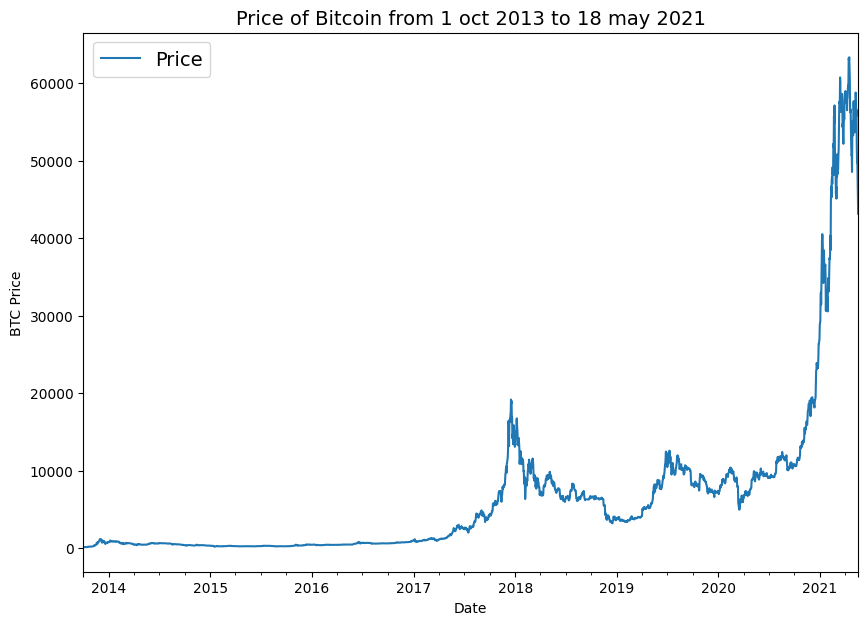

In [ ]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.title("Price of Bitcoin from 1 oct 2013 to 18 may 2021", fontsize=14)
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14, loc="upper left");

## Importing time series data with Python's CSV module

In [ ]:
from ast import With
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime
import numpy as np

timestamps = []
btc_price = []

with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timestamps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings)
    btc_price.append(float(line[2])) # get the closing price as float

timestamps[:5], btc_price[:5]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0)],
 [123.65499, 125.455, 108.58483, 118.67466, 121.33866])

Text(0, 0.5, 'BTC Price')

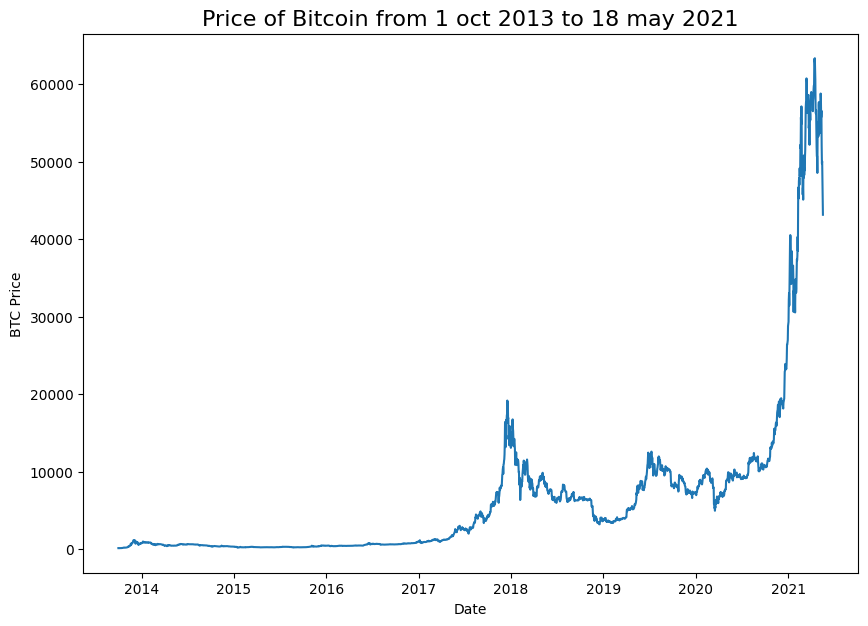

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(timestamps, btc_price)
plt.title("Price of Bitcoin from 1 oct 2013 to 18 may 2021", fontsize=16)
plt.xlabel("Date")
plt.ylabel("BTC Price")

## Format data part 1 : Create train and test sets of our time series data

### Creating train and test sets with time series data (the wrong way)

In [ ]:
bitcoin_prices[:5]

Price
Date                 
2013-10-01  123.65499
2013-10-02  125.45500
2013-10-03  108.58483
2013-10-04  118.67466
2013-10-05  121.33866

In [ ]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices.Price.to_numpy()

timesteps[:5], prices[:5]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000'], dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866]))

In [ ]:
# Wrong way to make train/test sets for time series data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps, #dates
                                                    prices, # BTC prices
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

In [ ]:
# Let's plot wrong train and test splits
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="train")
plt.scatter(X_test, y_test, s=5, label="test")
plt.title("Price of Bitcoin from 1 oct 2013 to 18 may 2021", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show();

### Create train & test sets for time series (the right way)

In [ ]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test - you can change these values as needed, e.g. 90/10, 95/5

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything beyond the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

In [ ]:
# Plot correctly made splits
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="train")
plt.scatter(X_test, y_test, s=5, label="test")
plt.title("Price of Bitcoin from 1 oct 2013 to 18 may 2021", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show();

## Create a plotting function

Typing plotting code is tedious, let's functionize it.

In [ ]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  """
  Plots timesteps (a series of points in time) against values (a series of values accross timesteps).

  Parameters
  ----------
  timesteps : array of timestep values
  values : array of values accross time
  format : style of plot, default "."
  start : where to start the plot (setting a value will) index from start of timesteps
  end : where to end the plot (similar to start but for the end)
  label : label to show on plot about values, default None
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  plt.title("Price of Bitcoin from 1 oct 2013 to 18 may 2021", fontsize=14)
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

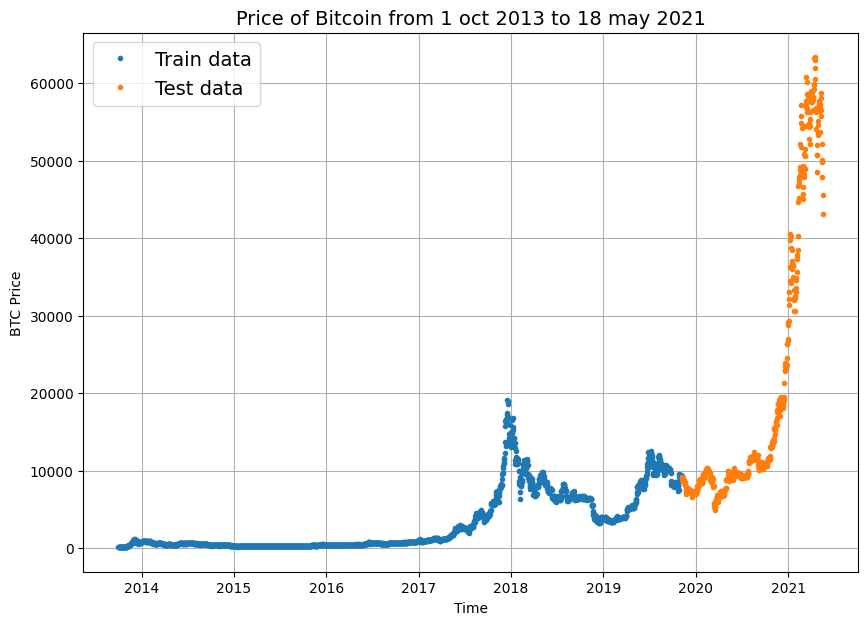

In [ ]:
# Test out plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Modelling Experiments

We've got some Bitcoin historical data, to model it, let's run a series of modelling experiments and see which model performs best.

Terms to be familiar with:
* **Horizon** = number of timesteps into the future we're going to predict
* **Window size** = number of timesteps we're going to use to predict **horizon**

Modelling experiments we're running:
* 0 Naive model (baseline)
* 1 Dense model, horizon = 1, window = 7
* 2 Same as 1, horizon = 1, window = 30
* 3 Same as 1, horizon 7, window = 30
* 4 Conv1D
* 5 LSTM
* 6 Same as 1 (but with multivariate data)
* 7 N-BEATS Algorithm
* 8 Ensemble (multiple models optimized on different loss functions)
* 9 Future prediction model (model to predict future values)
* 10 Sames as 1 (but with turkey data introduced)

## Model 0 : Naive forecast (baseline)

The formula looks like this :

$$\hat{y}_{t} = y_{t-1}$$

In English:

> The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (previous timestep) - this is for a horizon of 1.

In [ ]:
# Create a naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

In [ ]:
y_test[-10:]

array([58788.20967893, 58102.19142623, 55715.54665129, 56573.5554719 ,
       52147.82118698, 49764.1320816 , 50032.69313676, 47885.62525472,
       45604.61575361, 43144.47129086])

In [ ]:
# Plot naive
plt.figure(figsize=(10, 7))
# plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, format="-", start=350, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=350, label="Naive Forecast")

> 🛠️ **Exercise:** Spend 10 minutes reading the [simple forecast chapter of Forecasting : Principles in Practice.](https://otexts.com/fpp3/simple-methods.html) And have a search to find out why the naive forecast is hard to beat, does the term autoregressive come up?

## Evaluating a time series model

Let's look into some evaluation metrics for time series forecasting.

What are we doing ?

We're predicting a number, so that means we have a form of a regression problem.

Because we're working on a regression problem, we'll beed some regression-like metrics.

A few common regression metrics (which can also be used for time series forecasting):
* MAE - mean absolute error
* MSE - mean squared error
* RMSE - root mean square error
* MAPE/sMAPE - (symmetric) mean absolute percentage error
* MASE - mean absolute scaled error

The main thing we're evaluating here is : **how do our model's forecasts (y_pred) compare against the actual values (y_true or ground truth values) ?

>📖**Resource:** For a deeper dive on the various kinds of time series forecasting methods see [Forecasting: Principles and Practice chapter 5.8](https://otexts.com/fpp3/accuracy.html)

In [ ]:
import tensorflow as tf

In [ ]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_forecast = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shift of 1)

  return mae / mae_naive_forecast


In [ ]:
# Test MASE (this value should = 1 or be very close to 1 with the naive forecast)
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

np.float64(0.9995699939182624)

In [ ]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype (for metric calculation)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.MAE(y_true, y_pred)
  mse = tf.keras.metrics.mse(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mape(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae" : mae.numpy(),
          "mse" : mse.numpy(),
          "rmse" : rmse.numpy(),
          "mape" : mape.numpy(),
          "mase" : mase.numpy()}

That's one good looking evaluation function!

Let's now see if it works...

In [ ]:
naive_results = evaluate_preds(y_true=y_test[1:], y_pred=naive_forecast)
naive_results

{'mae': np.float32(567.9802),
 'mse': np.float32(1147547.0),
 'rmse': np.float32(1071.2362),
 'mape': np.float32(2.516525),
 'mase': np.float32(0.99957)}

In [ ]:
naive_forecast[-10:]

array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
       56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
       47885.62525472, 45604.61575361])

In [ ]:
tf.reduce_mean(y_test)

<tf.Tensor: shape=(), dtype=float64, numpy=20056.632963737222>

In [ ]:
tf.reduce_min(y_test), tf.reduce_max(y_test)

(<tf.Tensor: shape=(), dtype=float64, numpy=4944.7023359837>,
 <tf.Tensor: shape=(), dtype=float64, numpy=63346.7890351052>)

## Othe models you can usee for baselines and for actual forecasts

In this notebook, we're focused on Tensorflow and deep learning models.

However there are plenty of other styles of time series forecasting models you may want to experiment with :

https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/#other-kinds-of-time-series-forecasting-models-which-can-be-used-for-baselines-and-actual-forecasts

## Format Data Part 2: Windowing our dataset

Why do we window ?

We window our time series dataset to turn data into a supervised learning problem.

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]

```

In [ ]:
btc_price[:5]

[123.65499, 125.455, 108.58483, 118.67466, 121.33866]

In [ ]:
# What we want to do with our Bitcoin data
print(f"We want to use : {btc_price[:7]} to predict this : {btc_price[7]}")

We want to use : [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict this : 123.033


In [ ]:
# Let's setup global variables for window and horizon size
HORIZON = 1 # predict next 1 day
WINDOW_SIZE = 7 # use the past week of Bitcoin data to make the prediction

In [ ]:
# Create function to label windowed data
def get_labelled_window(x, horizon=HORIZON):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1
  Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

>🔑**Note**: `return x[:, :-horizon]` it means x[take all rows, take all columns except last column]

In [ ]:
# Test out the window labelling function
test_window, test_label = get_labelled_window(tf.expand_dims(range(8), axis=0))
print(f"Window : {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window : [0 1 2 3 4 5 6] -> Label: 7


We've got a way to label our windowed data.

However, this only works on a small scale.

We need a waay to do the abovea across our entire time series.

We could do this with Python for loops, however, for larget time series, that'd be quite low.

To speed things up, we'll leverage Numpy's array indexing - https://numpy.org/doc/stable/reference/arrays.indexing.html.

Our function will:
1. Create a window step of specific window size (e.g. [0, 1, 2, 3, 4, 5, 6])
2. Use NumPy indexing to create a 2D array of multiple window steps, for example :
```
[[0, 1, 2, 3, 4, 5, 6],
[1, 2, 3, 4, 5, 6, 7],
[2, 3, 4, 5, 6, 7, 8]]
```
3. Uses the 2D array of multiple window steps (from 2.) to index on a target series (e.g. the historical price of Bitcoin)
4. Uses our `get_labelled_window()` function we created above to turn the window steps into windows with a specified horizon

>📖**Resource**: The function we're about to create has been adapted from the following article:
https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5


In [ ]:
len(btc_price), btc_price[2786], len(prices)

(2787, 43144.4712908603, 2787)

In [ ]:
btc_price[:5], prices[:5] # if want to use x[window_indexes] turn the data into np.array

([123.65499, 125.455, 108.58483, 118.67466, 121.33866],
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866]))

🔑**Note:** Dalam kasus kita, kita memiliki panjang price = 2787, sedangkan kita hanya dapat membuat 2780 window. Artinya, tersisa 7 elemen terakhir yang tidak digunakan karena tidak cukup data untuk mengambil label (horizon) setelah window tersebut.

Namun, ini tidak berarti angka terakhir (yakni 43144.4712908603) tidak dipakai sama sekali.
Sebaliknya — angka tersebut masih digunakan sebagai bagian dari window terakhir (misalnya, sebagai elemen ke-7 dari window ke-2780), tetapi tidak dapat digunakan sebagai label karena sudah tidak ada lagi angka setelahnya.
```
Jumlah window = len(x) - (window + horizon - 1)
              = 10 - (3 + 2 - 1)
              = 10 - 4
              = 6 window

```

In [ ]:
# Create function to view NumPy arrays as windows
import numpy as np

def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns a 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for labelling later)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # Create 2D array of windows of size window_size

  # 3. Index on the target array (a time series) with 2D array of multiple window steps
  window_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_window(window_array)

  return windows, labels

In [ ]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [ ]:
# Window the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [ ]:
# Window the Last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


> 🔑**Note:** There's a function which does similar to the above in tf.keras.preprocessing, an extension could be to try and replicate what we've done using the premade function:
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array

In [ ]:
prices.dtype

dtype('float64')

In [ ]:
a = np.arange(WINDOW_SIZE + HORIZON)
a

array([0, 1, 2, 3, 4, 5, 6, 7])

In [ ]:
b = np.arange(len(prices) - (WINDOW_SIZE + HORIZON - 1))
b

array([   0,    1,    2, ..., 2777, 2778, 2779])

In [ ]:
b = np.expand_dims(np.arange(len(prices) - (WINDOW_SIZE + HORIZON - 1)), axis=0)
b

array([[   0,    1,    2, ..., 2777, 2778, 2779]])

In [ ]:
c = np.expand_dims(np.arange(len(prices) - (WINDOW_SIZE + HORIZON - 1)), axis=1)
c

array([[   0],
       [   1],
       [   2],
       ...,
       [2777],
       [2778],
       [2779]])

In [ ]:
b = np.expand_dims(np.arange(len(prices) - (WINDOW_SIZE + HORIZON - 1)), axis=0).T
b

array([[   0],
       [   1],
       [   2],
       ...,
       [2777],
       [2778],
       [2779]])

You can using axis=0 then transpose or using axis = 1 for expand_dims function

In [ ]:
(a + b)

array([[   0,    1,    2, ...,    5,    6,    7],
       [   1,    2,    3, ...,    6,    7,    8],
       [   2,    3,    4, ...,    7,    8,    9],
       ...,
       [2777, 2778, 2779, ..., 2782, 2783, 2784],
       [2778, 2779, 2780, ..., 2783, 2784, 2785],
       [2779, 2780, 2781, ..., 2784, 2785, 2786]])

➡️ Broadcasting rules NumPy mengatakan:

Jika dua array berbeda dimensi, NumPy akan "memperluas" array dengan dimensi 1 agar cocok dengan array lainnya.

Ya! ✅ Itu benar sekali. Konsep broadcasting di NumPy berakar dari matematika, khususnya dalam operasi matriks dan vektor, tapi NumPy memperluasnya dengan cara yang praktis dan efisien untuk pemrograman.

Jadi intinya mengapa window_step & window array bisa seperti itu jika ditambahkan, itu berasal dari konsep matematika
```
[[0],        +     [0, 1, 2, 3]   →   [0+0, 0+1, 0+2, 0+3]
 [1],                              →   [1+0, 1+1, 1+2, 1+3]
 [2]]                              →   [2+0, 2+1, 2+2, 2+3]

=>
[[0, 1, 2, 3],
 [1, 2, 3, 4],
 [2, 3, 4, 5]]
 ```

Ini adalah cara kerja dari sliding window
```
Index:    0   1   2   3   4   5   6   7
Prices:  [10, 20, 30, 40, 50, 60, 70, 80]

Window 1: [10, 20, 30] --> [40, 50]
Window 2:     [20, 30, 40] --> [50, 60]
Window 3:         [30, 40, 50] --> [60, 70]
Window 4:             [40, 50, 60] --> [70, 80]
```
yang valid hanya 4, walaupun sebenarnya ( window_size = 3 + horizon =2) adalah 5 tetapi jika kita meneruskannya hingga 5, window 5 akan seperti :
`Window 5 = [50, 60, 70] --> [80, ?]`
terlihat bahwa window 5 sudah keluar batas maka dari itu window yang valid hanya 4.

## Turning windows into training and test sets

In [ ]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_size=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_size)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [ ]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [ ]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [ ]:
test_windows[:5], test_labels[:5]

(array([[9290.89660239, 9202.41545055, 9369.62808116, 9326.59962378,
         9335.75240233, 9226.48582088, 8794.35864452],
        [9202.41545055, 9369.62808116, 9326.59962378, 9335.75240233,
         9226.48582088, 8794.35864452, 8798.04205463],
        [9369.62808116, 9326.59962378, 9335.75240233, 9226.48582088,
         8794.35864452, 8798.04205463, 9081.18687849],
        [9326.59962378, 9335.75240233, 9226.48582088, 8794.35864452,
         8798.04205463, 9081.18687849, 8711.53433917],
        [9335.75240233, 9226.48582088, 8794.35864452, 8798.04205463,
         9081.18687849, 8711.53433917, 8760.89271814]]),
 array([[8798.04205463],
        [9081.18687849],
        [8711.53433917],
        [8760.89271814],
        [8749.52059102]]))

In [ ]:
len(full_windows) * 0.8

2224.0

In [ ]:
# Check to see if train labels are the same (berfore and after window split)
np.array_equal(tf.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

In [ ]:
train_labels[:3], y_train[:3]

(array([[123.033  ],
        [124.049  ],
        [125.96116]]),
 array([123.65499, 125.455  , 108.58483]))

Dikarenakan terdapat perbedaan shape yakni y_train (2229) dan train_labels (2224) saat dikali dengan 0.8. ini membuat terdapat data yang tidak ada pada y_train tapi ada pada di train_labels karena data y_train tersebut berpindah ke y_test

In [ ]:
train_labels[-5:], y_test[:2]

(array([[9369.62808116],
        [9326.59962378],
        [9335.75240233],
        [9226.48582088],
        [8794.35864452]]),
 array([9226.48582088, 8794.35864452]))

In [ ]:
train_labels[:3], train_labels[-3:], y_train[WINDOW_SIZE:WINDOW_SIZE+3], y_train[-3:]

(array([[123.033  ],
        [124.049  ],
        [125.96116]]),
 array([[9335.75240233],
        [9226.48582088],
        [8794.35864452]]),
 array([123.033  , 124.049  , 125.96116]),
 array([9369.62808116, 9326.59962378, 9335.75240233]))

In [ ]:
len(train_labels), len(y_train)

(2224, 2229)

## Make a modelling checkpoint callback

Because our model's performance will fluctuate from experiment to experiment, we're going to write a model checkpoint so we can compare apples to apples

More specifically, we want to compare each of our model's best performances against the other model's best performances.

For example if our model performs the best on epoch 55 (but we're training for 100 epochs), we want to load and evaluate the model saved on epoch 55.

We can create a modelling checkppoint callback using the following:
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

In [ ]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_checkpoint_callback(model_name, save_path="model_experiment"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name+".keras"),
                                            verbose=0, # Only output a limited amount of text
                                            save_best_only=True)

## Model 1: Dense model (window = 7, horizon = 1)

Our first deep model is going to be a simple dense model:
* A single dense layer with 128 hidden units and ReLU
* An output layer with linear activation (no activation)
* Adam optimization and MAE loss function
* Batch sieze of 128 (previously we've used 32)
* 100 epochs

Why these values ?

I picked them out of experimentation.

* **Hyperparameters** = values a machine learning practitioner (you!) can adjust themselves
* **Parameters** = values a model learns on its own

In [ ]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [ ]:
from tensorflow.keras import layers
import tensorflow as tf

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# 1. Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation
],name="model_1_dense") # name our model so we can save it

# 2. Compile
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

# 3. Fit the model
history_1 = model_1.fit(x=train_windows,
                        y=train_labels,
                        epochs=100,
                        verbose=1,
                        batch_size=128,
                        validation_data=(test_windows, test_labels),
                        callbacks=[create_checkpoint_callback(model_name=model_1.name)])

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - loss: 2171.8049 - mae: 2171.8049 - mse: 12763232.0000 - val_loss: 2197.2659 - val_mae: 2197.2659 - val_mse: 11254089.0000
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 386.8821 - mae: 386.8821 - mse: 477674.2812 - val_loss: 1604.3600 - val_mae: 1604.3600 - val_mse: 6011144.5000
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 199.4540 - mae: 199.4540 - mse: 178380.8281 - val_loss: 1108.1724 - val_mae: 1108.1724 - val_mse: 3313921.0000
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 165.5878 - mae: 165.5878 - mse: 137617.7656 - val_loss: 927.1901 - val_mae: 927.1901 - val_mse: 2645584.7500
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 155.9170 - mae: 155.9170 - mse: 126257.6797 - val_loss: 877.9008 - val_mae: 877.9008 - val_mse: 2508293.7500
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 153.0948 - mae: 153.0948 - mse: 122532.7578 - val_loss: 863.0547 - val_mae: 863.054

In [ ]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 284.6037 - mae: 284.6037 - mse: 344949.2812


[567.2319946289062, 567.2319946289062, 1165743.5]

In [ ]:
# Load in saved best performing model_1 and evaluate it on test data
from tensorflow.keras.models import load_model
load_model_1 = load_model("/content/model_experiment/model_1_dense.keras")
load_model_1.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 282.6203 - mae: 282.6203 - mse: 345273.7188


[565.30126953125, 565.30126953125, 1161318.875]

## Making forecasts with a model (on the test dataset)

To make "forecasts" on the test dataset (note: these won't be actual forecasts, they're only pseudo forecasts because actual forecasts are into the future), let's write a function to:

1. Take in a train model
2. Takes in some input data (same kind of data the model was trained on)
3. Passes the input data to the model's `predict()` method
4. Returns the predictions

In [ ]:
def make_preds(model, input_data):
  """
  Uses model to make predictions input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [ ]:
# Make predictions using model_1 on the test dataset and view results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8869.869, 8817.118, 9049.826, 8786.74 , 8778.142, 8758.095,
        8683.826, 8561.595, 8476.146, 8542.853], dtype=float32)>)

In [ ]:
test_labels.shape, model_1_preds.shape

((556, 1), TensorShape([556]))

In [ ]:
# Evaluate preds
model_1_results = evaluate_preds(tf.squeeze(test_labels), model_1_preds)
model_1_results

{'mae': np.float32(567.23206),
 'mse': np.float32(1165743.6),
 'rmse': np.float32(1079.696),
 'mape': np.float32(2.5460792),
 'mase': np.float32(0.9964696)}

In [ ]:
naive_results

{'mae': np.float32(567.9802),
 'mse': np.float32(1147547.0),
 'rmse': np.float32(1071.2362),
 'mape': np.float32(2.516525),
 'mase': np.float32(0.99957)}

In [ ]:
len(X_test)

558

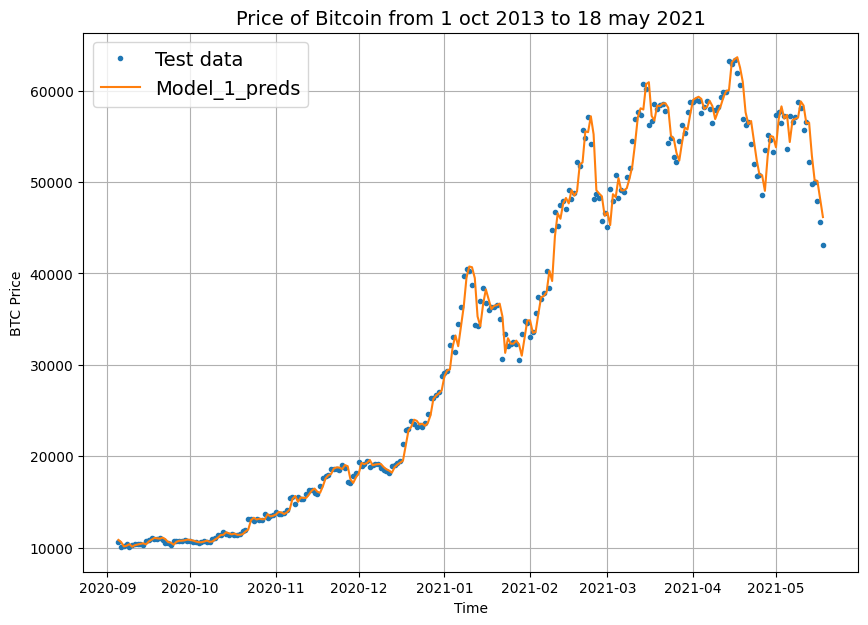

In [ ]:
# Let's plot our model 1 predictions
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 label="Test data")

plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_1_preds,
                 format="-",
                 start=offset,
                 label="Model_1_preds")

## Model 2: Dense (window = 30, horizon = 1)

In [ ]:
HORIZON = 1 # predict one step at a time (one day of Bitcoin prices)
WINDOW_SIZE = 30 # use 30 timesteps in past

In [ ]:
# Make windows data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [ ]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels,
                                                                                test_size=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [ ]:
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name="model_2_dense")

# Compile
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
history_2 = model_2.fit(x=train_windows,
                        y=train_labels,
                        epochs=100,
                        verbose=0,
                        batch_size=128,
                        validation_data=(test_windows, test_labels),
                        callbacks=[create_checkpoint_callback(model_2.name)])

In [ ]:
# Evaluate model 2 on test data
model_2.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 310.1813


602.9058837890625

In [ ]:
# Load in the best performing model
model_2 = load_model("/content/model_experiment/model_2_dense.keras")
model_2.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 302.3341


592.3155517578125

In [ ]:
# Get forecast predictions
model_2_preds = make_preds(model_2, test_windows)
model_2_preds[:5]

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8885.281, 8819.902, 8801.854, 8626.584, 8404.174], dtype=float32)>

In [ ]:
test_labels.shape

(552, 1)

In [ ]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(tf.squeeze(test_labels), model_2_preds)
model_2_results

{'mae': np.float32(592.3154),
 'mse': np.float32(1212031.2),
 'rmse': np.float32(1100.9229),
 'mape': np.float32(2.685165),
 'mase': np.float32(1.0353732)}

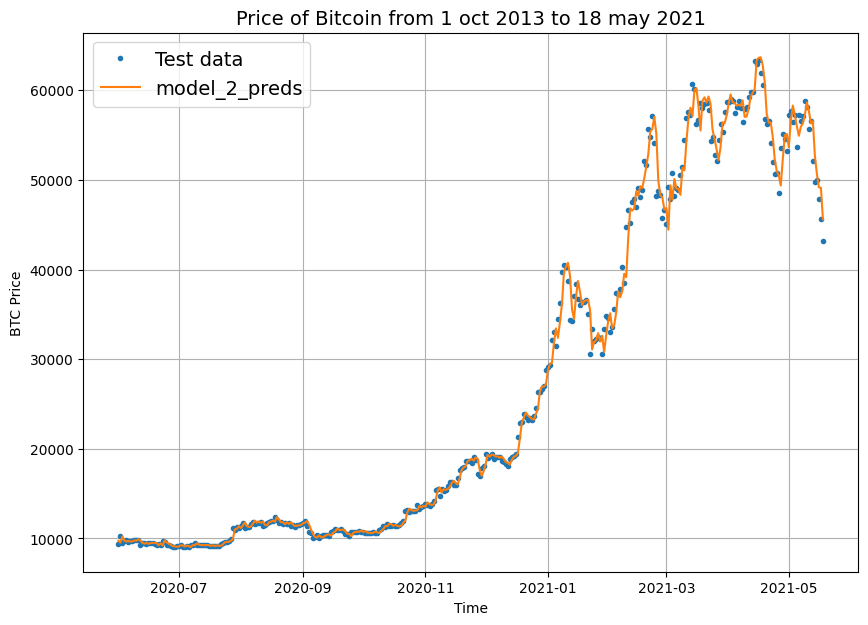

In [ ]:
offset = 200
plt.figure(figsize=(10, 7))
# Account for test_window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_2_preds,
                 start=offset,
                 format="-",
                 label="model_2_preds")

## Model 3: Dense (window = 30, horizon = 7)

In [ ]:
HORIZON = 7
WINDOW_SIZE = 30

In [ ]:
full_windows, full_labels = make_windows(prices,
                                         window_size=WINDOW_SIZE,
                                         horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels,
                                                                                test_size=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [ ]:
tf.random.set_seed(42)

# Create model (same as model_1 except with different data input and output sizes)
model_3 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_3_dense")

# Compile
model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
history_3 = model_3.fit(train_windows,
                        train_labels,
                        epochs=100,
                        batch_size=128,
                        verbose=0,
                        validation_data=(test_windows, test_labels),
                        callbacks=[create_checkpoint_callback(model_name=model_3.name)])

In [ ]:
# Evaluate the model on the test data
model_3.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 356.5660


695.9186401367188

In [ ]:
# Load best version of model_3 and evaluate
model_3 = load_model("/content/model_experiment/model_3_dense.keras")
model_3.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 352.5317


690.1027221679688

In [ ]:
# Make predictions with model_3
model_3_preds = model_3.predict(test_windows)
model_3_preds[:5]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


array([[8758.252 , 8704.721 , 8763.728 , 8799.153 , 8842.11  , 8678.612 ,
        8876.289 ],
       [8767.93  , 8641.094 , 8708.972 , 8743.423 , 8688.685 , 8500.718 ,
        8656.908 ],
       [8434.736 , 8508.488 , 8478.718 , 8885.1045, 8469.19  , 8530.396 ,
        8677.061 ],
       [8289.654 , 8466.387 , 8501.161 , 8673.477 , 8466.069 , 8527.538 ,
        8762.266 ],
       [8150.156 , 8464.678 , 8445.508 , 8516.103 , 8540.041 , 8633.94  ,
        8518.506 ]], dtype=float32)

In [ ]:
model_3_preds.shape, test_labels.shape

((551, 7), (551, 1))

In [ ]:
# Evaluate model_3 results
model_3_results = evaluate_preds(y_true=test_labels,
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([ 117.72433 ,  171.88908 ,  109.72266 ,  113.8503  ,  277.08377 ,
         189.87291 ,  119.96596 ,  641.30597 ,  674.78076 ,  151.64104 ,
         286.16232 ,   80.69078 ,  101.946495,  322.22614 ,  111.346886,
         270.75607 ,  116.856026,  271.14822 ,  256.66818 ,  136.93275 ,
         205.31125 ,   86.05978 ,  140.67201 ,   77.675575,   57.979702,
         274.63965 ,  167.1566  ,  216.1527  ,  155.02162 ,  108.76507 ,
         231.8042  ,  121.2025  ,  281.64062 ,  380.35672 ,  657.23065 ,
          80.54283 ,   80.978935,  134.90067 ,   77.47656 ,  128.47244 ,
          46.515068,   90.09096 ,  141.91434 ,   80.3109  ,   73.94127 ,
          98.66051 ,  237.45256 ,  117.13086 ,  122.99435 ,  311.71616 ,
         111.89495 ,  129.08377 ,   88.76137 ,  252.24525 ,  464.0565  ,
          96.1107  ,  278.94928 ,  119.69015 ,   56.365025,  107.93046 ,
         119.301895,  486.62277 ,  179.19308 ,   80.796036,  121.73131 ,
          69.858536,  480.50336 ,  283.78012

## Make our evaluation function work for larger horizons

In [ ]:
model_2_results["mae"].ndim

0

In [ ]:
model_3_results["mae"].ndim

1

In [ ]:
model_3.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 352.5317 


690.1027221679688

In [ ]:
tf.reduce_mean(model_3_results["mae"])

<tf.Tensor: shape=(), dtype=float32, numpy=690.1027221679688>

In [ ]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype (for metric calculation)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.MAE(y_true, y_pred)
  mse = tf.keras.metrics.mse(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mape(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, we want to reduce metrics to a single value)
  if y_pred.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae" : mae.numpy(),
          "mse" : mse.numpy(),
          "rmse" : rmse.numpy(),
          "mape" : mape.numpy(),
          "mase" : mase.numpy()}

In [ ]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds(y_true=test_labels,
                                 y_pred=model_3_preds)
model_3_results

{'mae': np.float32(690.1027),
 'mse': np.float32(1638898.8),
 'rmse': np.float32(736.31934),
 'mape': np.float32(3.1375573),
 'mase': np.float32(1.2044704)}

We've made and evaluated predictions with `model_3`, let's visualize, visualize, visualize!

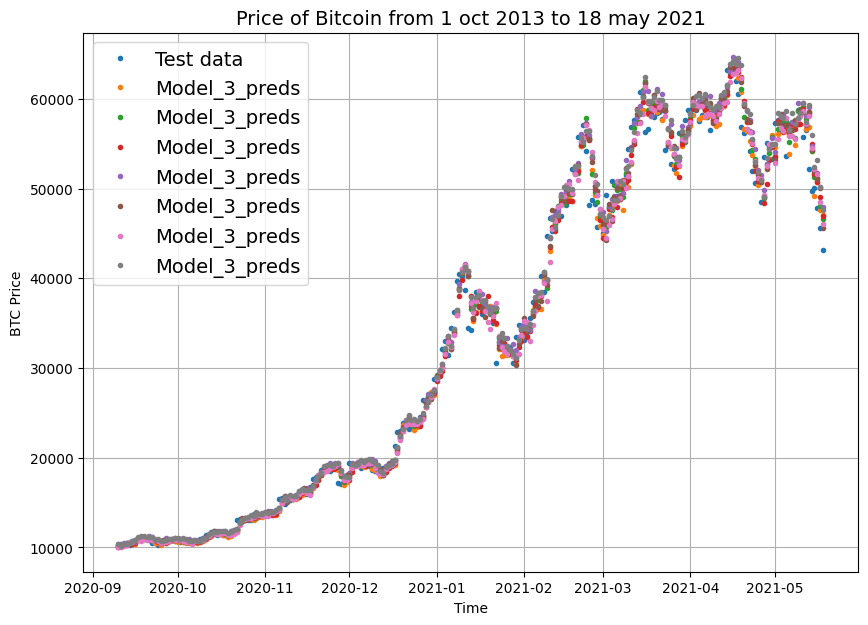

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="Model_3_preds")

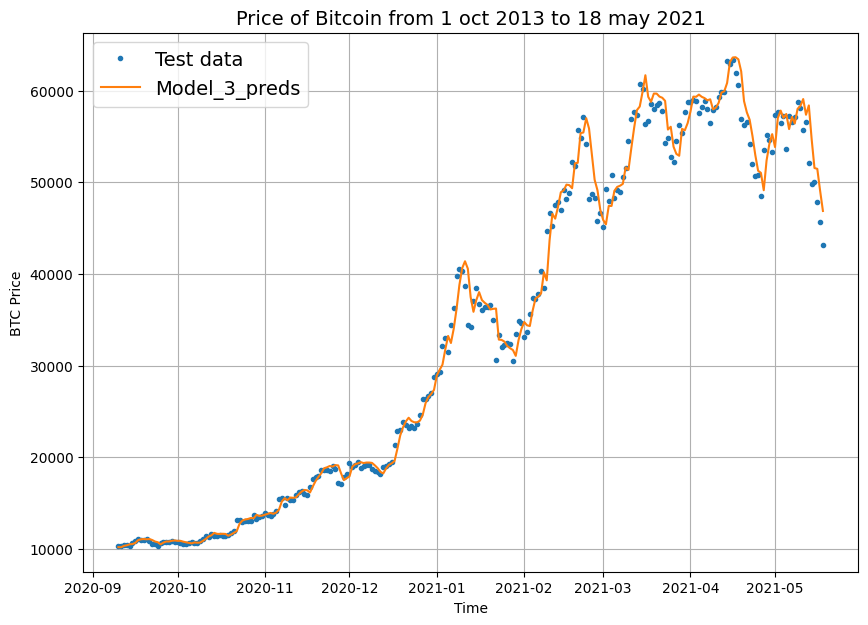

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset, label="Test data")

plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=tf.reduce_mean(model_3_preds, axis=1),
                 start=offset,
                 format="-",
                 label="Model_3_preds")

## Which of our models is performing the best so far ?

So we've trained a few models, now let's compare them and see how they've gone...

<Axes: >

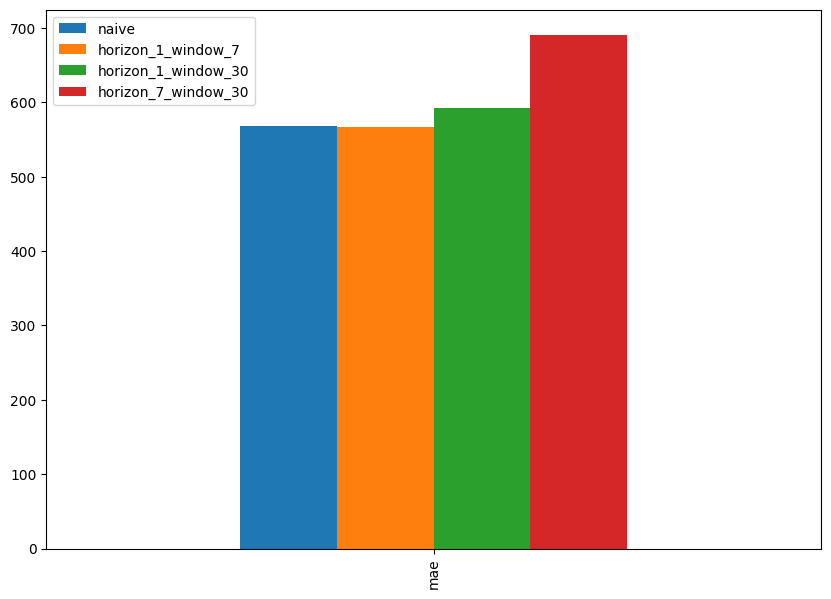

In [ ]:
pd.DataFrame({"naive" : naive_results["mae"],
              "horizon_1_window_7" : model_1_results["mae"],
              "horizon_1_window_30" : model_2_results["mae"],
              "horizon_7_window_30" : model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7) ,kind="bar")

> 🔑**Note:** Youg might be wondering, why are the naive results so good ? One of the reasons could be due the presence of autocorrelation in the data. If a time series has autocorrelation it means the value at `t+1` (the next timestep) is typically close to the value at `t` (the current timestep). In other words, today's value is probably pretty close to yesterday's value. Of coursse, this isn't always the case but when it is (stock market prices often seem autocorrelated but often fluctuate randomly), a naive model will often get fairly good results

> 📖**Resource:** For more on how autocorrelation influences a model's predictions, see the article "How (not to use Machine Learning for time series forecasting: Avoiding the pitfalls by VegardFlovik"

## Model 4: Conv1D

In [ ]:
HORIZON = 1 # predict next day of Bitcoin prices
WINDOW_SIZE = 7 # use previous week worth data

In [ ]:
# Create windowed data
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [ ]:
# Create train/test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows,
                                                                                full_labels,
                                                                                test_size=0.2)
len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2224, 2224, 556, 556)

To use the Conv1D layer, we need an input shape of: `(batch_size, timesteps, input_dim)`...

However your data isn't in that shape yet...

In [ ]:
# Check data input shape
train_windows[0].shape # returns (INDOW_SIZE, )

(7,)

In [ ]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = train_windows[0]
x

array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])

In [ ]:
expand_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for `input_dim`

In [ ]:
# Test our our lambda layer
print(f"Original shape : {x.shape}") # (WINDOW_SIZE)
print(f"Expand layer shape : {expand_layer(x).shape}")
print(f"Expand layer : {expand_layer(x)}")

Original shape : (7,)
Expand layer shape : (7, 1)
Expand layer : [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


Input shape:

If data_format="channels_last": A 3D tensor with shape: (batch_shape, steps, channels)

If data_format="channels_first": A 3D tensor with shape: (batch_shape, channels, steps)

In [ ]:
tf.random.set_seed(42)

def expand_dims(x):
  return tf.expand_dims(x, axis=1)

model_4 = tf.keras.Sequential([
    layers.Lambda(expand_dims, name="expand_dims"),
    layers.Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="relu"),
    layers.Dense(HORIZON)
], name="model_4_conv1d")

model_4.compile(loss="MAE",
                optimizer=tf.keras.optimizers.Adam())

history_4 = model_4.fit(train_windows,
                        train_labels,
                        epochs=100,
                        verbose=0,
                        batch_size=120,
                        validation_data=(test_windows, test_labels),
                        callbacks=[create_checkpoint_callback(model_4.name)])

In [ ]:
model_4.summary()

Model: "model_4_conv1d"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ expand_dims (Lambda)            │ (None, 1, 7)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1, 128)         │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1, 1)           │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,213 (55.52 KB)

 Trainable params: 4,737 (18.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,476 (37.02 KB)

In [ ]:
model_2.summary()

Model: "model_2_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 128)            │         3,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,293 (48.02 KB)

 Trainable params: 4,097 (16.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,196 (32.02 KB)

In [ ]:
model_4.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 287.5332


571.5576171875

In [ ]:
# Load back in best performing Conv1S and re-evaluate

import keras
import tensorflow as tf

keras.config.enable_unsafe_deserialization()
model_4 = tf.keras.models.load_model("/content/model_experiment/model_4_conv1d.keras",
                                     custom_objects={"expand_dims" : expand_dims})
model_4.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 281.9038


564.9856567382812

In [ ]:
# Make prediction
model_4_preds = tf.expand_dims(tf.squeeze(model_4.predict(test_windows)), axis=1)
model_4_preds[:5]

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[8869.491],
       [8787.689],
       [9033.177],
       [8788.798],
       [8736.307]], dtype=float32)>

In [ ]:
model_4_preds.shape, test_labels.shape

(TensorShape([556, 1]), (556, 1))

In [ ]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=test_labels,
                                 y_pred=model_4_preds)
model_4_results

{'mae': np.float32(564.9857),
 'mse': np.float32(1164409.4),
 'rmse': np.float32(564.9857),
 'mape': np.float32(2.5205789),
 'mase': np.float32(0.99252343)}

In [ ]:
model_1_results

{'mae': np.float32(567.23206),
 'mse': np.float32(1165743.6),
 'rmse': np.float32(1079.696),
 'mape': np.float32(2.5460792),
 'mase': np.float32(0.9964696)}

## Model 5: RNN (LSTM)

In [ ]:
tf.random.set_seed(42)

def expand_dims(x):
  return tf.expand_dims(x, axis=1)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE,), name="input_layer")
x = layers.Lambda(expand_dims, name="expand_dims")(inputs)
# x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128, activation="relu")(x)
# x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(HORIZON, name="output_layer")(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=outputs, name="model_5_LSTM")

# Compile
model_5.compile(loss="MAE",
                optimizer=tf.keras.optimizers.Adam())

# Fit
history_5 = model_5.fit(x=train_windows,
                        y=train_labels,
                        epochs=100,
                        batch_size=128,
                        verbose=1,
                        validation_data=(test_windows, test_labels),
                        callbacks=[create_checkpoint_callback(model_name=model_5.name)])

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - loss: 2725.7878 - val_loss: 12569.7529
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1714.2117 - val_loss: 6019.9321
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 663.7474 - val_loss: 1382.4160
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 227.8018 - val_loss: 1182.1445
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 181.5133 - val_loss: 989.2997
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 170.5907 - val_loss: 990.5952
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 169.8484 - val_loss: 1003.7445
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 169.2966 - val_loss: 1010.6772
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 169.1363 - val_loss: 1001.5703
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 168.2120 - val_loss: 995.7963
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 167.3887 - val_loss: 991.6142
Epoch

In [ ]:
model_5.summary()

Model: "model_5_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ expand_dims (Lambda)            │ (None, 1, 7)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │        69,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 209,285 (817.52 KB)

 Trainable params: 69,761 (272.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 139,524 (545.02 KB)

In [ ]:
# Load in best version of model 5 and evaluate on the test data
keras.config.enable_unsafe_deserialization()
model_5 = load_model("/content/model_experiment/model_5_LSTM.keras",
                     custom_objects={"expand_dims" : expand_dims})

model_5.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 305.5957


605.3628540039062

In [ ]:
# Make prediction with our LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:5]

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8962.173, 8791.088, 8938.212, 8804.631, 8704.734], dtype=float32)>

In [ ]:
# Evaluate model 5 predictions
model_5_results = evaluate_preds(y_true=test_labels,
                                 y_pred=model_5_preds)
model_5_results

{'mae': np.float32(605.36285),
 'mse': np.float32(1299375.9),
 'rmse': np.float32(605.36285),
 'mape': np.float32(2.7506254),
 'mase': np.float32(30.116755)}

In [ ]:
model_1_results

{'mae': np.float32(567.23206),
 'mse': np.float32(1165743.6),
 'rmse': np.float32(1079.696),
 'mape': np.float32(2.5460792),
 'mase': np.float32(0.9964696)}

## Make a multivariate time series dataset

Before we add a feature to our time series, what is a feature we can use ?

One feature we could add is whether or not i tweeted on that day...

* day 1 - 0
* day 2 - 1
* day 3 - 0

What's a better feature to use ?

How about the bitcoin halving events ?

https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving

In [ ]:
# Let's make a multivariate time series
bitcoin_prices[:5]

Price
Date                 
2013-10-01  123.65499
2013-10-02  125.45500
2013-10-03  108.58483
2013-10-04  118.67466
2013-10-05  121.33866

In [ ]:
# Let's add the bitcoin halving events to our dataset
block_reward_1 = 50 # 3 January 2009 - this block reward isn't in our dataset (our dataset) (our data starts from 01 October 2013)
block_reward_2 = 25 # 8 November 2012 -
block_reward_3 = 12.5 # 9 July 2016 -
block_reward_4 = 6.25 # 18 May 2020

# Block reward dates
block_reward_datetime_2 = np.datetime64("2012-11-08")
block_reward_datetime_3 = np.datetime64("2016-07-09")
block_reward_datetime_4 = np.datetime64("2020-05-18")

In [ ]:
# Create data ranges of where specific block_reward values should be
block_reward_2_days = (block_reward_datetime_3 - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_datetime_4 - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2421)

In [ ]:
# Add in a block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None
bitcoin_prices_block.head()

Price block_reward
Date                              
2013-10-01  123.65499         None
2013-10-02  125.45500         None
2013-10-03  108.58483         None
2013-10-04  118.67466         None
2013-10-05  121.33866         None

In [ ]:
# Add in block_reward values as a feature to our dataframe
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

Price block_reward
Date                              
2013-10-01  123.65499           25
2013-10-02  125.45500           25
2013-10-03  108.58483           25
2013-10-04  118.67466           25
2013-10-05  121.33866           25

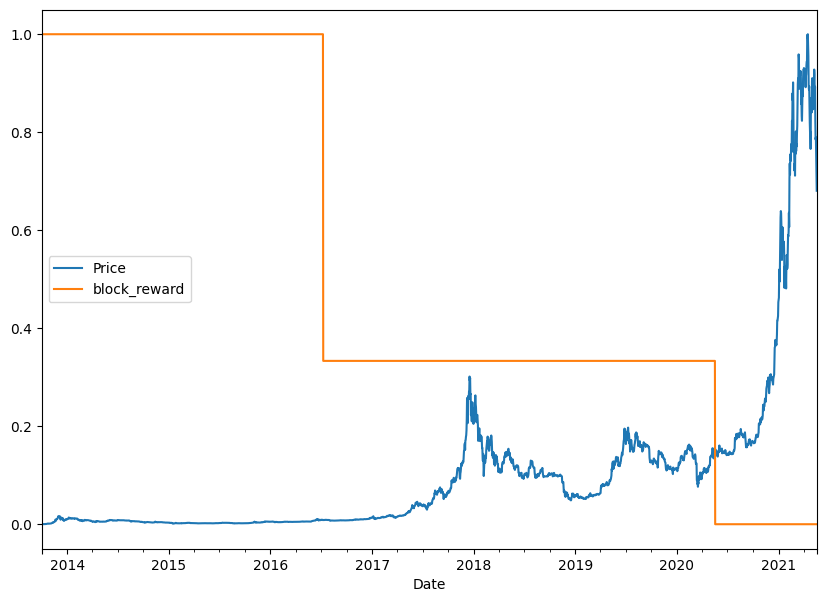

In [ ]:
# Plot the block reward vs price over time
from sklearn.preprocessing import minmax_scale
scaled_block_price_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)

scaled_block_price_df.plot(figsize=(10, 7));

## Making a windowed dataset with pandas

Previously, we've turned our univariate time series into windowed dataset using the helper functions above.

Hovever, since we've got multivariate data, these functions won't work.

Not to worry, we can use the pandas.DataFrame.shift() method to window our multivariate data.

https://pandas.python.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html

In [ ]:
# Setup dataset hyparameters
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Make a copy of the Bitcoin historical data with block reward feature

bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)

bitcoin_prices_windowed

Price block_reward       Price+1       Price+2  \
Date                                                                
2013-10-01    123.654990           25           NaN           NaN   
2013-10-02    125.455000           25    123.654990           NaN   
2013-10-03    108.584830           25    125.455000    123.654990   
2013-10-04    118.674660           25    108.584830    125.455000   
2013-10-05    121.338660           25    118.674660    108.584830   
...                  ...          ...           ...           ...   
2021-05-14  49764.132082         6.25  52147.821187  56573.555472   
2021-05-15  50032.693137         6.25  49764.132082  52147.821187   
2021-05-16  47885.625255         6.25  50032.693137  49764.132082   
2021-05-17  45604.615754         6.25  47885.625255  50032.693137   
2021-05-18  43144.471291         6.25  45604.615754  47885.625255   

                 Price+3       Price+4       Price+5       Price+6  \
Date                                                                 
2013-10-01           NaN           NaN           NaN           NaN   
2013-10-02           NaN           NaN           NaN           NaN   
2013-10-03           NaN           NaN           NaN           NaN   
2013-10-04    123.654990           NaN           NaN           NaN   
2013-10-05    125.455000    123.654990           NaN           NaN   
...                  ...           ...           ...           ...   
2021-05-14  55715.546651  58102.191426  58788.209679  57107.120672   
2021-05-15  56573.555472  55715.546651  58102.191426  58788.209679   
2021-05-16  52147.821187  56573.555472  55715.546651  58102.191426   
2021-05-17  49764.132082  52147.821187  56573.555472  55715.546651   
2021-05-18  50032.693137  49764.132082  52147.821187  56573.555472   

                 Price+7  
Date                      
2013-10-01           NaN  
2013-10-02           NaN  
2013-10-03           NaN  
2013-10-04           NaN  
2013-10-05           NaN  
...                  ...  
2021-05-14  56583.849879  
2021-05-15  57107.120672  
2021-05-16  58788.209679  
2021-05-17  58102.191426  
2021-05-18  55715.546651  

[2787 rows x 9 columns]

What we've done is created a way to window our dataset directly from a pandas dataframe.

```
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```

In [ ]:
# Create X (windows) and y (horizons) features
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)

X.head()

block_reward     Price+1     Price+2     Price+3     Price+4  \
Date                                                                       
2013-10-08          25.0  121.794998  120.655327  121.338661  118.674660   
2013-10-09          25.0  123.032997  121.794998  120.655327  121.338661   
2013-10-10          25.0  124.049004  123.032997  121.794998  120.655327   
2013-10-11          25.0  125.961159  124.049004  123.032997  121.794998   
2013-10-12          25.0  125.279663  125.961159  124.049004  123.032997   

               Price+5     Price+6     Price+7  
Date                                            
2013-10-08  108.584831  125.455002  123.654991  
2013-10-09  118.674660  108.584831  125.455002  
2013-10-10  121.338661  118.674660  108.584831  
2013-10-11  120.655327  121.338661  118.674660  
2013-10-12  121.794998  120.655327  121.338661

In [ ]:
# Make train and test sets using indexing
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [ ]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    # layers.Dense(128, acitvation="relu"),
    layers.Dense(HORIZON)
], name="model_6_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
history_6 = model_6.fit(X_train,
                        y_train,
                        epochs=100,
                        batch_size=120,
                        verbose=1,
                        validation_data=(X_test, y_test),
                        callbacks=[create_checkpoint_callback(model_name=model_6.name)]),

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 1087.0747 - val_loss: 1249.5844
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 213.6837 - val_loss: 1091.0182
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 163.9454 - val_loss: 885.8694
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 151.0928 - val_loss: 887.4136
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 148.5198 - val_loss: 821.8632
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 140.1587 - val_loss: 765.7635
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 135.2824 - val_loss: 747.3775
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 132.5124 - val_loss: 731.2441
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 130.0055 - val_loss: 715.0335
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 128.3988 - val_loss: 698.8032
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 125.7840 - val_loss: 687.4385
Epoch 12

In [ ]:
# Load in and evaluate best performing model
model_6 = load_model("/content/model_experiment/model_6_multivariate.keras")
model_6.evaluate(X_test, y_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 282.5901


565.5194091796875

In [ ]:
# Make predictions with multivariate model
model_6_preds = model_6.predict(X_test)
model_6_preds[:5]

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


array([[8853.654],
       [8801.346],
       [9065.293],
       [8755.575],
       [8742.936]], dtype=float32)

In [ ]:
# Evaluate predictions to get eval metrics
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': np.float32(565.5194),
 'mse': np.float32(1157235.5),
 'rmse': np.float32(565.5194),
 'mape': np.float32(2.5262105),
 'mase': np.float32(30.15623)}

In [ ]:
naive_results

{'mae': np.float32(567.9802),
 'mse': np.float32(1147547.0),
 'rmse': np.float32(1071.2362),
 'mape': np.float32(2.516525),
 'mase': np.float32(0.99957)}

For a challenge on different ways to potentially improve the multivariate time series model, see the reference here :
https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/#model-6-dense-multivariate-time-series

## Model 7: N-BEATS algorithm

Let's now try build the biggest baddest (though maybe not the baddest, as in, it perform really well...) time series forecasating model we've built so far.

More specifically, we're going to be replicating the algorithm in Figure 1 from the following paper: https://arxiv.org/pdf/1905.10437.pdf

Why ?
- This will allow us to practice replicating a paper with TensorFlow code
- We will see how to use TensorFlow layer subclassing (to make our own custom layers)
- Get experience using the Functional API to create a custom architecture
- Potentially get state of the art results on our problem.

### Building and testing the N-BEATS block layer

Because the N-BEATS block layer doesn't exist in TensorFlow, we've got to create it.

To create custom layers and models in TensorFlow we can use subclassing:

https://www.tensorflow.org/guide/keras/custom_layers_and_models

In [ ]:
# Create NBeatsBlock layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size : int,
               theta_size : int,
               horizon : int,
               n_neurons : int,
               n_layers : int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)

    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLu activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]

    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and the forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

Let's test our NBeatsBlock class.

To do we'll make some dummy inputs and outputs.

In [ ]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
tf.random.set_seed(42)
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON, #backcast + forecast
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [ ]:
# Create dummy inputs (have to be same size as (input_size))
dummy_input = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect dense layer input requirements (ndim=2)
dummy_input

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [ ]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_input)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast : {tf.squeeze(backcast.numpy())}")
print(f"Forecast : {tf.squeeze(forecast.numpy())}")

Backcast : [-0.6536937  -0.4941454  -0.20820391 -0.10363938 -0.27243266 -0.25927532
 -0.4418325 ]
Forecast : 0.0888780802488327


### Preparing data for the N-BEATS algorithm using `tf.data`

To make our input data load as fast as possible we're going to be adhering to the performant data pipeline steps in the tf.data guide: https://www.tensorflow.org/guide/data_performance

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Create N-BEATS data inputs (N-BEATS work with univariate time series)
bitcoin_prices.head()

Price
Date                 
2013-10-01  123.65499
2013-10-02  125.45500
2013-10-03  108.58483
2013-10-04  118.67466
2013-10-05  121.33866

In [ ]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()

for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)

bitcoin_prices_nbeats

Price       Price+1       Price+2       Price+3  \
Date                                                                 
2013-10-01    123.654990           NaN           NaN           NaN   
2013-10-02    125.455000    123.654990           NaN           NaN   
2013-10-03    108.584830    125.455000    123.654990           NaN   
2013-10-04    118.674660    108.584830    125.455000    123.654990   
2013-10-05    121.338660    118.674660    108.584830    125.455000   
...                  ...           ...           ...           ...   
2021-05-14  49764.132082  52147.821187  56573.555472  55715.546651   
2021-05-15  50032.693137  49764.132082  52147.821187  56573.555472   
2021-05-16  47885.625255  50032.693137  49764.132082  52147.821187   
2021-05-17  45604.615754  47885.625255  50032.693137  49764.132082   
2021-05-18  43144.471291  45604.615754  47885.625255  50032.693137   

                 Price+4       Price+5       Price+6       Price+7  
Date                                                                
2013-10-01           NaN           NaN           NaN           NaN  
2013-10-02           NaN           NaN           NaN           NaN  
2013-10-03           NaN           NaN           NaN           NaN  
2013-10-04           NaN           NaN           NaN           NaN  
2013-10-05    123.654990           NaN           NaN           NaN  
...                  ...           ...           ...           ...  
2021-05-14  58102.191426  58788.209679  57107.120672  56583.849879  
2021-05-15  55715.546651  58102.191426  58788.209679  57107.120672  
2021-05-16  56573.555472  55715.546651  58102.191426  58788.209679  
2021-05-17  52147.821187  56573.555472  55715.546651  58102.191426  
2021-05-18  49764.132082  52147.821187  56573.555472  55715.546651  

[2787 rows x 8 columns]

In [ ]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train = X[:split_size]
X_test = X[split_size:]
y_train = y[:split_size]
y_test = y[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2224, 556, 2224, 556)

In [ ]:
# Time to make our dataset performant using tf.data.API
train_features_data = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_data = tf.data.Dataset.from_tensor_slices(y_train)

test_features_data = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_data = tf.data.Dataset.from_tensor_slices(y_test)

# Combine labels and features by zipping together -> (features, labels)
train_data = tf.data.Dataset.zip((train_features_data, train_labels_data))
test_data = tf.data.Dataset.zip((test_features_data, test_labels_data))

# Batch and prefetch
BATCH_SIZE = 1024
train_dataset = train_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Setting up hyperparameters for N-BEATS algorithm

The N-BEATS algorithm has a fair few number of parameters, many of them can be found in Table 18: https://arxiv.org/pdf/1905.10437.pdf

In [ ]:
# Values from N-BEATS layer
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACK = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = WINDOW_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for residual connections

Before we can craft our N-BEATS model, we need two layers for the residual connections (subtract and add).

The N-BEATS algorithm uses double residual stacking to help train its deeper architecture (section 3.2 of N-BEATS paper).

For more on residual connections see: https://en.wikipedia.org/wiki/Residual_neural_network

And here : https://paperswithcode.com/method/resnet

In [ ]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

# Get outputs
print(f"Input tensor : {tensor_1} & {tensor_2}")
print(f"Subtracted : {subtracted}")
print(f"added : {added}")

Input tensor : [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted : [10 10 10 10 10 10 10 10 10 10]
added : [10 12 14 16 18 20 22 24 26 28]


### Building, compiling and fitting the N-BEATS algorithm

1. Setup an instance of the N-BEATS block layer using `NBeatsBlock` (this'll be the initial block used for network, the rest will be created as part of stacks)
2. Create an input layer for the N-BEATS stack (we'll be using the Keras Functional API)
3. Make the initial backcast and forecasts for the model with the layer created in (1)
4. Use for loop to create stacks of block layers
5. Use the `NBeatsBlock` class within the for loop in (4) to create blocks which return backcasts and block-level forecasts
6. Create the double residual stacking using subtract and add layers
7. Put the model inputs and outputs together using `tf.keras.Model()`
8. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default setting as per section 5.2 of N-BEATS paper
9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:
 -  Early Stopping - because the model will be training fofr so long, we'll stop it early if it stops improving
 - Reduce LR on Plateau - if model stops improving, try lowering the learning to reduce the amount it updates its weights each time (take smaller steps towards best performance)

In [ ]:
%%time

tf.random.set_seed(42)

# 1. Setup and instance of NBeatsBlock
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="initialBlock")

# 2. Create input to stack
stack_input = layers.Input(shape=(INPUT_SIZE,), name="stack_input")

# 3. Create initial backcast and forecast input (backwards prediction + horizon prediction)
residuals, forecast = nbeats_block_layer(stack_input)

# 4. Create stacks of block layers
for i, _ in enumerate(range(N_STACK-1)): # first stack is already created in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as the forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsblock_{i}"
   )(residuals) #  pass in the residuals

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subctract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, outputs=forecast, name="model_7_NBEATS")

# 8. Compile model with MAE loss
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# 9. Fit the model with EarlyStopping and ReduceLROnPlateu
history_7 = model_7.fit(train_dataset,
                        epochs=N_EPOCHS,
                        verbose=0,
                        validation_data=test_dataset,
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                                    patience=200,
                                                                    restore_best_weights=True),
                                   tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                        patience=100,
                                                                        verbose=1)])


Epoch 960: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 1343: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1443: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
CPU times: user 3min 40s, sys: 14.5 s, total: 3min 54s
Wall time: 6min 51s


In [ ]:
# Evaluate N-Beats model on the test dataset
model_7.evaluate(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 570.2174


570.2174072265625

In [ ]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


<tf.Tensor: shape=(556,), dtype=float32, numpy=
array([ 8834.423 ,  8775.095 ,  9043.092 ,  8744.371 ,  8749.242 ,
        8770.605 ,  8655.909 ,  8477.584 ,  8491.926 ,  8513.912 ,
        8227.553 ,  8126.927 ,  8082.5913,  7657.5903,  7297.9062,
        7318.981 ,  7079.127 ,  7211.9424,  7175.582 ,  7500.4805,
        7411.417 ,  7739.4785,  7583.973 ,  7404.518 ,  7300.566 ,
        7323.1113,  7188.5146,  7384.4424,  7509.029 ,  7543.259 ,
        7567.3184,  7357.5786,  7226.5493,  7186.347 ,  7183.5015,
        7222.17  ,  7109.466 ,  7107.0044,  6901.679 ,  6615.307 ,
        7322.6   ,  7201.652 ,  7150.1343,  7305.939 ,  7279.094 ,
        7142.841 ,  7242.611 ,  7208.925 ,  7162.394 ,  7217.3247,
        7304.1064,  7378.701 ,  7260.955 ,  7178.5957,  7162.2046,
        6964.382 ,  7241.8096,  7340.366 ,  7359.334 ,  7716.8813,
        8079.5635,  8142.2134,  7885.163 ,  8094.7524,  8079.5176,
        8138.4844,  8120.0273,  8724.903 ,  8899.621 ,  8786.355 ,
        8953.9

In [ ]:
# Evaluate N-BEATS model preds
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': np.float32(570.2174),
 'mse': np.float32(1153761.1),
 'rmse': np.float32(1074.1327),
 'mape': np.float32(2.5877125),
 'mase': np.float32(1.001714)}

In [ ]:
naive_results

{'mae': np.float32(567.9802),
 'mse': np.float32(1147547.0),
 'rmse': np.float32(1071.2362),
 'mape': np.float32(2.516525),
 'mase': np.float32(0.99957)}

In [ ]:
model_1_results

{'mae': np.float32(567.23206),
 'mse': np.float32(1165743.6),
 'rmse': np.float32(1079.696),
 'mape': np.float32(2.5460792),
 'mase': np.float32(0.9964696)}

### Plotting the N-BEATS architecture we've created

In [ ]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model

plot_model(model_7, to_file="nbeats_model.png", show_shapes=True, show_layer_names=True)

## Model 8: Creating an ensemble (stacking different models together)

An ensemble leverages the wisdom of the crowd effect.

It combines many *different* models to predict a common goal

In [ ]:
HORIZON, WINDOW_SIZE

(1, 7)

In [ ]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        num_epochs=1000,
                        test_data=test_dataset,
                        num_iter=10,
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"])
  """
  # Make empty list for trained ensemble models
  ensemble_model = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing : {loss_function} for {num_epochs} epochs, model number : {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
          # Initialize dense layers with normal distribution for estimating prediction intervals later on
         layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
         layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
         layers.Dense(horizon)
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])

      # Fit the current model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])

      # Append fitted model to list of ensemble models
      ensemble_model.append(model)

  return ensemble_model

In [ ]:
%%time
# Get list of trained ensemble models
ensemble_model = get_ensemble_models(num_iter=5,
                                     num_epochs=1000)

Optimizing model by reducing : mae for 1000 epochs, model number : 0

Epoch 356: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 836: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 936: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing : mse for 1000 epochs, model number : 0

Epoch 480: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 580: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing : mape for 1000 epochs, model number : 0

Epoch 189: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 289: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing : mae for 1000 epochs, model number : 1

Epoch 793: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 968: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Opt

### Make predictions with our ensemble model

In [ ]:
ensemble_model

[<Sequential name=sequential, built=True>,
 <Sequential name=sequential_1, built=True>,
 <Sequential name=sequential_2, built=True>,
 <Sequential name=sequential_3, built=True>,
 <Sequential name=sequential_4, built=True>,
 <Sequential name=sequential_5, built=True>,
 <Sequential name=sequential_6, built=True>,
 <Sequential name=sequential_7, built=True>,
 <Sequential name=sequential_8, built=True>,
 <Sequential name=sequential_9, built=True>,
 <Sequential name=sequential_10, built=True>,
 <Sequential name=sequential_11, built=True>,
 <Sequential name=sequential_12, built=True>,
 <Sequential name=sequential_13, built=True>,
 <Sequential name=sequential_14, built=True>]

In [ ]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_model, y_true):
  ensemble_preds = []
  for model in ensemble_model:
    model_preds = model.predict(y_true)
    ensemble_preds.append(model_preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [ ]:
# Create a list of ensemble predictions
%%time
ensemble_preds = make_ensemble_preds(ensemble_model=ensemble_model,
                                     y_true=test_dataset)
ensemble_preds

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
CPU times: user 2.28 s, sys: 69.9 ms, total: 2.35 s
Wall time: 2.62 s


<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8797.632,  8808.472,  9051.47 , ..., 50367.24 , 48182.51 ,
        46303.117],
       [ 8793.582,  8781.787,  9046.594, ..., 49770.094, 48677.09 ,
        46337.734],
       [ 8782.017,  8777.486,  9020.849, ..., 49713.05 , 47384.066,
        45596.44 ],
       ...,
       [ 8817.263,  8786.53 ,  9094.74 , ..., 50231.895, 48193.223,
        46344.13 ],
       [ 8687.352,  8719.434,  9088.148, ..., 49826.74 , 48545.844,
        46214.594],
       [ 8802.98 ,  8793.185,  9113.54 , ..., 50921.023, 48585.02 ,
        46065.543]], dtype=float32)>

Our ensemble preds come out in multiple dimensions but to combine into **point predictions** we can leverage the mean of all of the predictions
 or the median - https://machinelearningmastery.com/combine-predictions-for-ensemble-learning/

In [ ]:
# Evaluate ensemble model predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_preds)
ensemble_results

{'mae': np.float32(576.81195),
 'mse': np.float32(1166437.1),
 'rmse': np.float32(1079.9717),
 'mape': np.float32(2.6186829),
 'mase': np.float32(1.013299)}

In [ ]:
ensemble_results_mean = tf.reduce_mean(ensemble_preds, axis=0)
ensemble_results_mean = evaluate_preds(y_true=y_test,
                                       y_pred=ensemble_results_mean)
ensemble_results_mean

{'mae': np.float32(567.64185),
 'mse': np.float32(1139901.9),
 'rmse': np.float32(1067.6619),
 'mape': np.float32(2.5677745),
 'mase': np.float32(0.9971895)}

In [ ]:
ensemble_results_median = np.median(ensemble_preds, axis=0)
ensemble_results_median = evaluate_preds(y_true=y_test,
                                       y_pred=ensemble_results_median)
ensemble_results_median

{'mae': np.float32(568.26385),
 'mse': np.float32(1143566.8),
 'rmse': np.float32(1069.3768),
 'mape': np.float32(2.573216),
 'mase': np.float32(0.9982822)}

In [ ]:
model_1_results

{'mae': np.float32(567.23206),
 'mse': np.float32(1165743.6),
 'rmse': np.float32(1079.696),
 'mape': np.float32(2.5460792),
 'mase': np.float32(0.9964696)}

### Plotting the prediction intervals (uncertainty estimates) for our ensemble

So far we've been making point predictions with our models.

E.g. horizon = 1, our model predicts tomorrow's price of Bitcoin will be $50,000 USD

Wouldn't it be helpful if we knew a range of where that prediction came from ?

Instead of 50,000 USD on the dot, how about 48,000 to 52,000 USD ?

One way to get the 95% confidence prediction intervals for a deep learning model is the bootstrap method:
1. Take the predictions from a number of randomly initialized models (we've got this thanks to our ensemble models)
2. Measure the standard deviation of the predictions
3. Multiply the standard deviation by 1.96 (assuming the distribution is Gaussian/Normal, 95% of observations fail within 1.96 standard deviations of the mean)
4. To get the prediction interval upper and lower bounds, add and subtract the value obtained in (3) to the mean/median of the predictions made in (1)


  - https://en.wikipedia.org/wiki/1.96
  - https://eng.uber.com/neural-networks-uncertainty-estimation

In [ ]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions from a number of random of randomly initialized models

  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)

  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std

  # 4. Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval

  return lower, upper

In [ ]:
# Get the upper and lower bounds of the 95% percent predictions interval
lower, upper = get_upper_lower(ensemble_preds)
lower, upper

(<tf.Tensor: shape=(556,), dtype=float32, numpy=
 array([ 8700.713 ,  8715.159 ,  8999.039 ,  8628.882 ,  8675.612 ,
         8650.547 ,  8598.138 ,  8423.004 ,  8397.121 ,  8485.174 ,
         8125.633 ,  8050.0317,  7996.253 ,  7560.0244,  7219.535 ,
         7260.384 ,  6995.948 ,  7139.647 ,  7035.843 ,  7463.948 ,
         7339.58  ,  7675.6914,  7503.9785,  7321.18  ,  7268.26  ,
         7253.4146,  7150.738 ,  7357.8735,  7469.599 ,  7504.6284,
         7503.641 ,  7270.8354,  7177.1304,  7135.973 ,  7137.781 ,
         7196.716 ,  7030.061 ,  7070.025 ,  6816.164 ,  6539.9644,
         7281.3994,  7032.645 ,  7082.256 ,  7190.5776,  7174.419 ,
         7105.321 ,  7174.297 ,  7172.4233,  7143.083 ,  7184.9395,
         7277.499 ,  7353.129 ,  7206.8203,  7120.092 ,  7122.804 ,
         6892.287 ,  7230.74  ,  7283.285 ,  7324.988 ,  7652.78  ,
         8004.6133,  8102.0728,  7794.5576,  8006.146 ,  8052.919 ,
         8124.146 ,  8062.2783,  8663.539 ,  8822.583 ,  8704.451 ,

> 📖**Resource:** Many of the steps we've taken above have inspired/referenced from the Machine Learning Mastery blog post on [Prediction Intervals for Deep Learning Neural Networks](https://machinelearningmastery.com/prediction-intervals-for-deep-learning-neural-networks/)

In [ ]:
X_test[:5].index

DatetimeIndex(['2019-11-10', '2019-11-11', '2019-11-12', '2019-11-13',
               '2019-11-14'],
              dtype='datetime64[ns]', name='Date', freq=None)

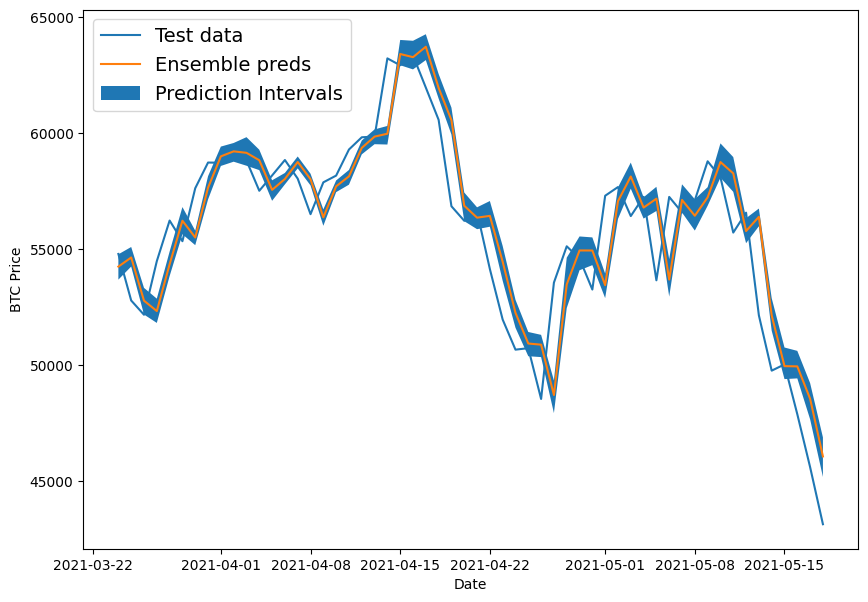

In [ ]:
# Get the median/mean values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset = 500
plt.figure(figsize=(10, 7))
plt.plot(X_test[offset:].index, y_test[offset:], '-', label="Test data")
plt.plot(X_test[offset:].index, ensemble_median[offset:], '-', label="Ensemble preds")
# To plot the upper and lower bounds, let's use fill_between
plt.fill_between(X_test[offset:].index,
                 lower[offset:],
                 upper[offset:],
                 label="Prediction Intervals")
plt.ylabel("BTC Price")
plt.xlabel("Date")
plt.legend(loc="upper left", fontsize=14)

Hmm...

So far all of our models predictions have been lagging behind the test data...

As is they're replicating what the naive model does and just predict the previous timestep as the next timestep.

> 🔑**Note:** These prediction intervals are estimates themselves. And they have been created with the assumption that our model's data is from a normal distribution.

## Aside: two types of uncertainty (coconut and subway)

Uncertainty estimates in machine learning seek out to qualitatively and quantitatively answer the questions:
1. What can my model know ? (with perfect data, what's possible for a model to learn?)
2. What doesn't my model know ? (what can a model never predict ? Or would it helpful if a model could tell you that when it's making a prediction, it doesn't actually know if it's right or not?)

There are two major types of uncertainty in machine learning you should know about:
- **Aleatoric uncertainty** - this type of uncertainty cannot be reduced and it is often referred as "data" uncertainty or "subway" uncertainty
- **Epistemic uncertainty** - this type of uncertainty can be reduced, it also referred to as "model" or "coconut" uncertainty
- https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/#learning-more-on-uncertainty

## Model 9: Train a model on the full historical data to make predictions into the future

So far all of our models have predicted on the test dataset, however, this is only pseudofuture

Let's now build a model which is capable of predicting into the future!

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
bitcoin_prices_windowed.head()

Price block_reward    Price+1    Price+2    Price+3  \
Date                                                                  
2013-10-01  123.65499           25        NaN        NaN        NaN   
2013-10-02  125.45500           25  123.65499        NaN        NaN   
2013-10-03  108.58483           25  125.45500  123.65499        NaN   
2013-10-04  118.67466           25  108.58483  125.45500  123.65499   
2013-10-05  121.33866           25  118.67466  108.58483  125.45500   

              Price+4  Price+5  Price+6  Price+7  
Date                                              
2013-10-01        NaN      NaN      NaN      NaN  
2013-10-02        NaN      NaN      NaN      NaN  
2013-10-03        NaN      NaN      NaN      NaN  
2013-10-04        NaN      NaN      NaN      NaN  
2013-10-05  123.65499      NaN      NaN      NaN

In [ ]:
bitcoin_prices_windowed.tail()

Price block_reward       Price+1       Price+2  \
Date                                                                
2021-05-14  49764.132082         6.25  52147.821187  56573.555472   
2021-05-15  50032.693137         6.25  49764.132082  52147.821187   
2021-05-16  47885.625255         6.25  50032.693137  49764.132082   
2021-05-17  45604.615754         6.25  47885.625255  50032.693137   
2021-05-18  43144.471291         6.25  45604.615754  47885.625255   

                 Price+3       Price+4       Price+5       Price+6  \
Date                                                                 
2021-05-14  55715.546651  58102.191426  58788.209679  57107.120672   
2021-05-15  56573.555472  55715.546651  58102.191426  58788.209679   
2021-05-16  52147.821187  56573.555472  55715.546651  58102.191426   
2021-05-17  49764.132082  52147.821187  56573.555472  55715.546651   
2021-05-18  50032.693137  49764.132082  52147.821187  56573.555472   

                 Price+7  
Date                      
2021-05-14  56583.849879  
2021-05-15  57107.120672  
2021-05-16  58788.209679  
2021-05-17  58102.191426  
2021-05-18  55715.546651

In [ ]:
# Train model on entire data to make predictions for the next day
X_all = bitcoin_prices_windowed.dropna().drop(["Price", "block_reward"], axis=1).to_numpy()
# Get labels
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

len(X_all), len(y_all)

(2780, 2780)

In [ ]:
# Turn data into efficient running tensors

features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# Combine features and labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# Batch and prefetch for optimal performance
BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [ ]:
tf.random.set_seed(42)

# Create model (nice and simple, just to test)
model_9 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_9_future_model")

# Compile
model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

# Fit model on all of the data to make future forecasts
history_9 = model_9.fit(dataset_all,
                        epochs=100,
                        verbose=0)

## Make predictions into future

In [ ]:
# How many timesteps to predict into the future ?
INTO_FUTURE = 14

To make predictions into the future we want a function which:
1. Takes as input:
 - a list of values (Bitcoin historical data)
 - a trained model (such as `model_9`)
 - a window into the future to predict (our `INTO_FUTURE` variable)
 - the window size a model was trained on (`WINDOW_SIZE`)
 - the model can only predict on the same kind of data it was trained on
2. Creates an empty list for future forecasts (this will be returned at the end of the end, when it's full of predictions) and extracts the last `WINDOW_SIZE` values from the input values
3. Loop `INTO_FUTURE` times making a prediction on `WINDOW_SIZE` sequences which update to remove the first value and append the latest prediction

In [ ]:
import numpy as np
# 1. Create function to make predictions into the future
def make_future_forecasts(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Make future forecasts into_future steps after values ends.

  Returns future forecasts as alist of floats
  """
  # 2. Create an empty list for future forecasts/prepare data to forecasts on
  future_forecast = []
  last_windows = values[-WINDOW_SIZE:]

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each
  for i in range(into_future):
    # Predict on the last window then append it again, again and again (our model will eventually start to make forecasts on its own)
    future_pred = model.predict(tf.expand_dims(last_windows, axis=0))
    print(f"Predicting on :\n{last_windows} -> Prediction : {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_windows = np.append(last_windows, future_pred)[-WINDOW_SIZE:]

  return future_forecast

In [ ]:
future_forecasts = make_future_forecasts(values=y_all,
                                         model=model_9,
                                         into_future=INTO_FUTURE)
future_forecasts

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
Predicting on :
[56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction : 55098.0546875

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicting on :
[52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 55098.0546875 ] -> Prediction : 52325.6484375

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicting on :
[49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 55098.0546875  52325.6484375 ] -> Prediction : 48418.5546875

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicting on :
[50032.69313676 47885.62525472 45604.61575361 43144.47129086
 55098.0546875  52325.6484375  48418.5546875 ] -> Prediction : 48206.140625

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicting on :
[47885.62525472 45604.61575361 43144.47129086 55098.0546875
 52325.6484375  48418.5546875  48206.140625  ] -> Prediction : 46184.8671875

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/ste

[np.float32(55098.055),
 np.float32(52325.65),
 np.float32(48418.555),
 np.float32(48206.14),
 np.float32(46184.867),
 np.float32(46662.24),
 np.float32(48137.227),
 np.float32(53881.72),
 np.float32(50923.21),
 np.float32(47067.87),
 np.float32(46929.367),
 np.float32(46502.65),
 np.float32(48469.5),
 np.float32(50468.785)]

 ### Plot future forecasts

In [ ]:
len(timesteps)

2787

In [ ]:
bitcoin_prices_windowed.tail()

Price block_reward       Price+1       Price+2  \
Date                                                                
2021-05-14  49764.132082         6.25  52147.821187  56573.555472   
2021-05-15  50032.693137         6.25  49764.132082  52147.821187   
2021-05-16  47885.625255         6.25  50032.693137  49764.132082   
2021-05-17  45604.615754         6.25  47885.625255  50032.693137   
2021-05-18  43144.471291         6.25  45604.615754  47885.625255   

                 Price+3       Price+4       Price+5       Price+6  \
Date                                                                 
2021-05-14  55715.546651  58102.191426  58788.209679  57107.120672   
2021-05-15  56573.555472  55715.546651  58102.191426  58788.209679   
2021-05-16  52147.821187  56573.555472  55715.546651  58102.191426   
2021-05-17  49764.132082  52147.821187  56573.555472  55715.546651   
2021-05-18  50032.693137  49764.132082  52147.821187  56573.555472   

                 Price+7  
Date                      
2021-05-14  56583.849879  
2021-05-15  57107.120672  
2021-05-16  58788.209679  
2021-05-17  58102.191426  
2021-05-18  55715.546651

In [ ]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datetime values ranging from start_date to start_date+into_future
  """
  start_date = start_date + np.timedelta64(offset, "D") # specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(into_future, "D") # specify end date

  return np.arange(start_date, end_date, dtype="datetime64[D]") # return a date range between start and end date

In [ ]:
# last timestep of timesteps (currently np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-05-18 00:00:00')

In [ ]:
# Get next two week of timesteps
next_time_steps = get_future_dates(start_date=last_timestep,
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

In [ ]:
# Insert last timesteps/final price into next time steps and future forecasts so the plot doesn't look janky
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecasts = np.insert(future_forecasts, 0, y_all[-1])
last_timestep, future_forecasts

(Timestamp('2021-05-18 00:00:00'),
 array([43144.473, 55098.055, 52325.65 , 48418.555, 48206.14 , 46184.867,
        46662.24 , 48137.227, 53881.72 , 50923.21 , 47067.87 , 46929.367,
        46502.65 , 48469.5  , 50468.785], dtype=float32))

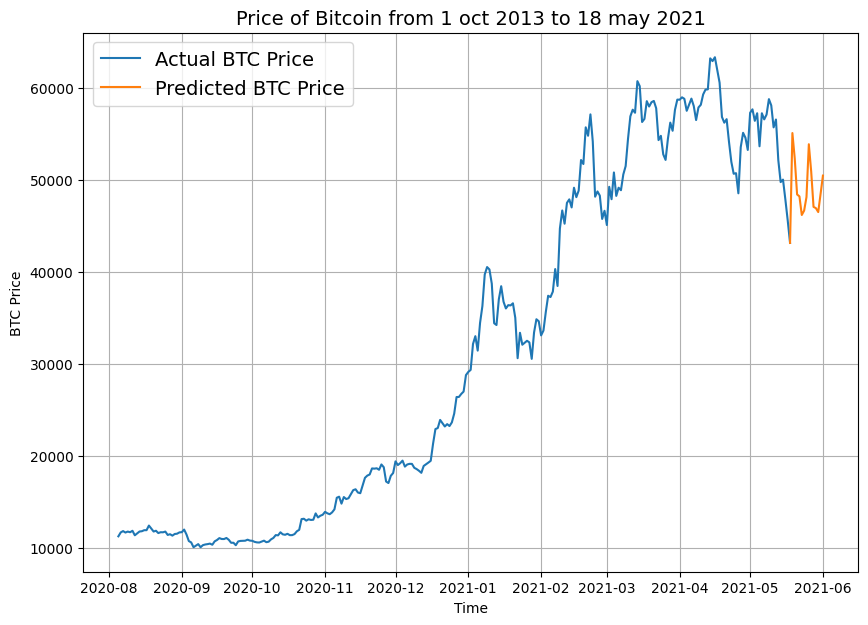

In [ ]:
# Plot future prices predictions of Bitcoins
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=bitcoin_prices_windowed.index, values=bitcoin_prices, start=2500, format="-",label="Actual BTC Price")
plot_time_series(timesteps=next_time_steps, values=future_forecasts, format="-", label="Predicted BTC Price")

## Model 10: Why forecasting is BS (the turkey problem 🦃)

In [ ]:
# Let's introduce turkey problem to our BTC data (price of BTC falls 100x in one day)
btc_price_turkey = btc_price.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

In [ ]:
# Manufacture an extrac price on the end (to showcase our Turkey problem)
btc_price_turkey[-10:]

[58788.2096789273,
 58102.1914262342,
 55715.5466512869,
 56573.5554719043,
 52147.8211869823,
 49764.1320815975,
 50032.6931367648,
 47885.6252547166,
 45604.6157536131,
 431.44471290860304]

In [ ]:
# Get the timesteps for the turkey problem
btc_timesteps_turkey = np.array(bitcoin_prices.index)
btc_timesteps_turkey[:10]

array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
       '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
       '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
       '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
       '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
      dtype='datetime64[ns]')

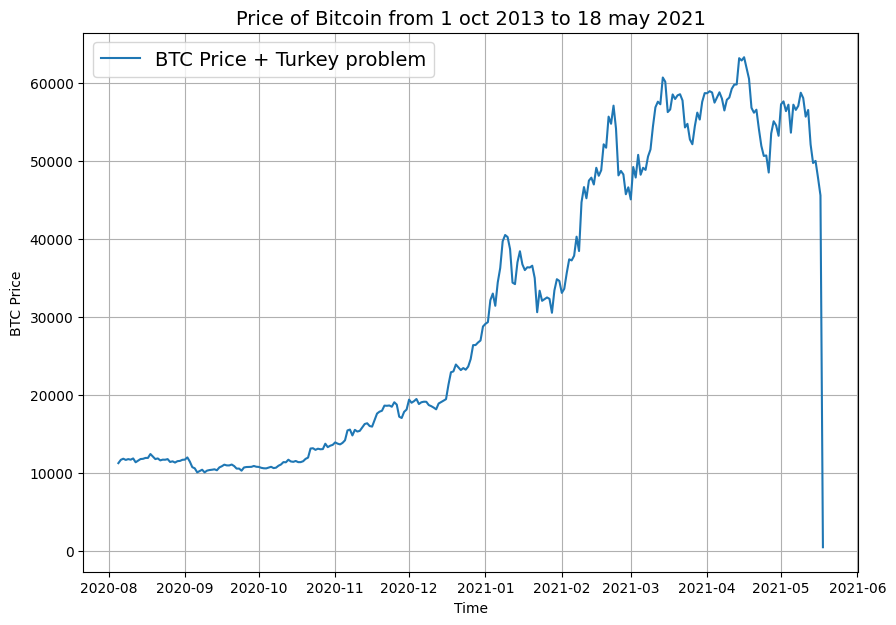

In [ ]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=btc_timesteps_turkey,
                 values=btc_price_turkey,
                 label="BTC Price + Turkey problem",
                 start=2500,
                 format="-")

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Create train and test sets for turkey problem data
full_windows, full_labels = make_windows(np.array(btc_price_turkey),
                                         window_size=WINDOW_SIZE,
                                         horizon=HORIZON)

X_train, X_test, y_train, y_test = make_train_test_splits(windows=full_windows,
                                                          labels=full_labels,
                                                          test_size=0.2)
len(X_train), len(X_test), len(y_train), len(y_test)

(2224, 556, 2224, 556)

In [ ]:
# Clone model 1 architecture for turkey model and fit the turkey model on the turkey data
turkey_model = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
],name="model_10_turkey_model")

turkey_model.compile(loss=tf.keras.losses.mae,
                 optimizer=tf.keras.optimizers.Adam())

history_turkey = turkey_model.fit(X_train, y_train,
                                  epochs=100,
                                  verbose=0,
                                  batch_size=128,
                                  validation_data=(X_test, y_test),
                                  callbacks=[create_checkpoint_callback(model_name=turkey_model.name)])

In [ ]:
# Evaluate model on test data
turkey_model.evaluate(X_test, y_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 295.7591


650.9774169921875

In [ ]:
# ,oad best performing turkey model and evaluate on test data
turkey_model = tf.keras.models.load_model("model_experiment/model_10_turkey_model.keras")
turkey_model.evaluate(X_test, y_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 292.5628


647.2354125976562

In [ ]:
# Make predictions with turkey model
turkey_preds = make_preds(turkey_model, X_test)
turkey_preds[:10], turkey_preds[-1]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


(<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8846.21  , 8769.299 , 9045.055 , 8783.867 , 8703.487 , 8754.98  ,
        8677.622 , 8502.1   , 8456.0205, 8528.481 ], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=float32, numpy=46117.18359375>)

In [ ]:
# Evaluate turkey preds
turkey_results = evaluate_preds(y_true=y_test,
                                y_pred=turkey_preds)
turkey_results

{'mae': np.float32(647.23535),
 'mse': np.float32(4912057.0),
 'rmse': np.float32(647.23535),
 'mape': np.float32(21.582405),
 'mase': np.float32(26.521887)}

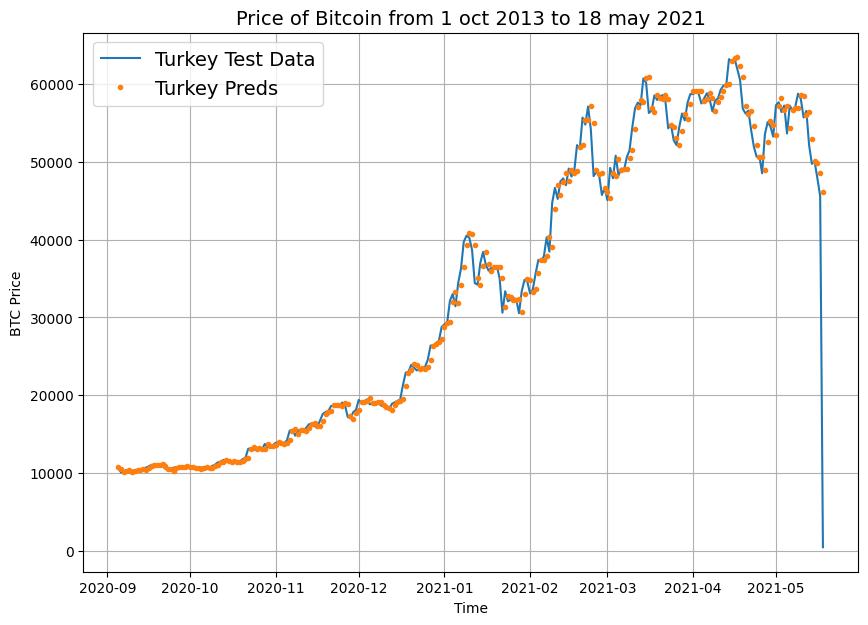

In [ ]:
plt.figure(figsize=(10, 7))
offset= 300
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=btc_price_turkey[-len(y_test):],
                 format="-",
                 start=offset,
                 label="Turkey Test Data")
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=turkey_preds,
                 format=".",
                 start=offset,
                 label="Turkey Preds")

## Compare models

In [ ]:
# Compare different model results ( w = window, h = horizon, e.g. w=7 means a window size of 7)
model_results = pd.DataFrame({"naive_model" : naive_results,
                              "model_1_dense_w7_h1" : model_1_results,
                              "model_2_dense_w30_h1" : model_2_results,
                              "model_3_dense_w30_h7" : model_3_results,
                              "model_4_CONV1D" : model_4_results,
                              "model_5_LSTM" : model_5_results,
                              "model_6_multivariate" : model_6_results,
                              "model_7_NBEATS" : model_7_results,
                              "model_8_ensemble" : ensemble_results,
                              "model_10_turkey" : turkey_results}).T
model_results

mae          mse         rmse       mape  \
naive_model           567.980225  1147547.000  1071.236206   2.516525   
model_1_dense_w7_h1   567.232056  1165743.625  1079.696045   2.546079   
model_2_dense_w30_h1  592.315430  1212031.250  1100.922852   2.685165   
model_3_dense_w30_h7  690.102722  1638898.750   736.319336   3.137557   
model_4_CONV1D        564.985718  1164409.375   564.985718   2.520579   
model_5_LSTM          605.362854  1299375.875   605.362854   2.750625   
model_6_multivariate  565.519409  1157235.500   565.519409   2.526211   
model_7_NBEATS        570.217407  1153761.125  1074.132690   2.587713   
model_8_ensemble      576.811951  1166437.125  1079.971680   2.618683   
model_10_turkey       647.235352  4912057.000   647.235352  21.582405   

                           mase  
naive_model            0.999570  
model_1_dense_w7_h1    0.996470  
model_2_dense_w30_h1   1.035373  
model_3_dense_w30_h7   1.204470  
model_4_CONV1D         0.992523  
model_5_LSTM          30.116755  
model_6_multivariate  30.156231  
model_7_NBEATS         1.001714  
model_8_ensemble       1.013299  
model_10_turkey       26.521887

<Axes: >

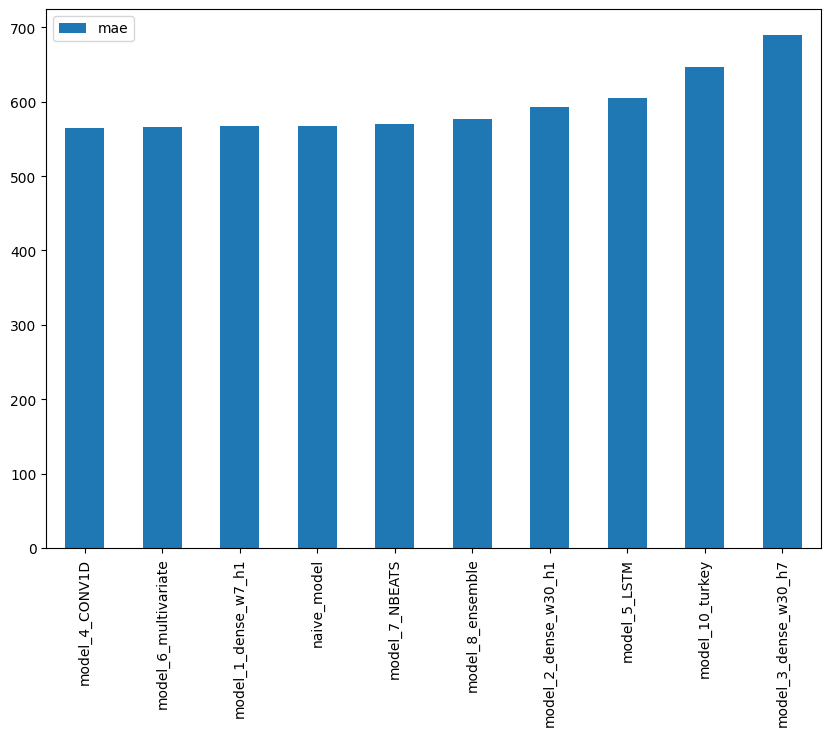

In [ ]:
# Sort model results by MAE and plot them
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar")